In [33]:
import sys, os, itertools, sklearn
sys.path.append('/home/roquero/CausalAggregation/Code')
import pandas as pd
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn import datasets
from sklearn.metrics import auc
from scipy.interpolate import UnivariateSpline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}, linewidth=100000)
from backfitting import Backfitting
from base_environment import BaseEnvironment
from collection_environment import CollectionEnvironment
from regression_method import PolynomialRegression, RandomForestRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


In [34]:
ik_h, se_h = [], (lambda input_samples:input_samples)
ik_x1, se_x1 = ['h'], (lambda input_samples: 2*input_samples[0] + input_samples[1])
ik_x2, se_x2 = ['h', 'x1'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x3, se_x3 = ['x1', 'x2'], (lambda input_samples: -input_samples[0] * 2*input_samples[1] + input_samples[2])
ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: np.log(1+np.abs(input_samples[0])) + input_samples[1] + input_samples[2])
ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
                                         input_samples[0] 
                                         + input_samples[1]**2
                                         #+ 0.5*input_samples[1]*input_samples[2]
                                         + 0.5*input_samples[1]*input_samples[2]*input_samples[3]
                                         - 0.5*input_samples[3]*input_samples[4]
                                         - input_samples[2]*input_samples[4] + input_samples[5])
ik_x5, se_x5 = ['x2', 'x4', 'y'], (lambda input_samples: 2*input_samples[0] + input_samples[1] - input_samples[2] + input_samples[3])

In [44]:
fh = {'input_keys':ik_h, 'structural_eq': se_h}
f1 = {'input_keys':ik_x1, 'structural_eq': se_x1}
f2 = {'input_keys':ik_x2, 'structural_eq': se_x2}
f3 = {'input_keys':ik_x3, 'structural_eq': se_x3}
f4 = {'input_keys':ik_x4, 'structural_eq': se_x4}
f5 = {'input_keys':ik_x5, 'structural_eq': se_x5}
fy = {'input_keys':ik_y, 'structural_eq': se_y}

sh = lambda n_samples: np.random.normal(size=n_samples)
s1 = lambda n_samples: np.random.normal(size=n_samples)
s2 = lambda n_samples: np.random.normal(size=n_samples)
s3 = lambda n_samples: np.random.normal(size=n_samples)
s4 = lambda n_samples: np.random.normal(size=n_samples)
s5 = lambda n_samples: np.random.normal(size=n_samples)
sy = lambda n_samples: np.random.normal(size=n_samples)

topo_order = ['h','x1','x2','x3','x4','y','x5']
y_key = 'y'
x_key = ['x1','x2','x3','x4','x5']

structural_equation_dict = {'x1':f1, 'x2':f2, 'x3':f3, 'y':fy, 'x4':f4, 'x5':f5, 'h':fh}
disturbance_sampler_dict = {'x1':s1, 'x2':s2, 'x3':s3, 'y':sy, 'x4':s4, 'x5':s5, 'h':sh}

base = BaseEnvironment(structural_equation_dict, disturbance_sampler_dict, topo_order, y_key, x_key)
coll_env = CollectionEnvironment(base)

In [45]:
coll_env.add_env('e1', {'x1':{'type':'independent'},'x2':{'type':'independent'}, 'x3':{'type':'independent'}}, 500)
coll_env.add_env('e2', {'x2':{'type':'independent'},'x4':{'type':'independent'}}, 500)
coll_env.add_env('e3', {'x4':{'type':'independent'},'x3':{'type':'independent'}}, 500)
coll_env.add_env('e4', {'x1':{'type':'independent'},'x5':{'type':'independent'}}, 500)


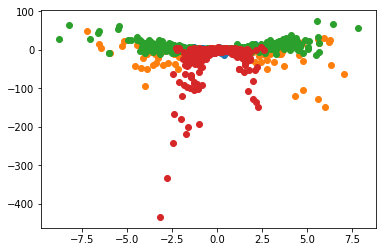

In [46]:
for key in coll_env.env.keys():
    plt.scatter(coll_env.env[key].data['X'][0,:],coll_env.env[key].data['Y'][:])

In [47]:
params_method = {'regression_method':'HuberRegressor',
                 'power_features': {
                     'e1':3,
                     'e2':2,
                     'e3':2,
                     'e4':2,
                     'e5':2,
                                     },
                 'selected_features':{
                     #'e1':['1','x1^0', 'x2^0','x2^2',  'x3^0', 'x1^0x2^0', 'x1^0x3^0',  'x2^0x3^0', 'x3^2', 'x1^3',
                     #      'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3'],
                     'e1':['1','x1^0', 'x2^0','x2^2',  'x3^0', 'x1^2', 'x1^0x2^0', 'x1^0x3^0',  'x2^0x3^0', 'x3^2', 'x1^3',
                           'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x2^0x3^0', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3'],
                     'e2':['x2^0x4^0'],
                     'e3':['x3^0x4^0'],
                     'e4':['x1^0x5^0'],
                 },
                 'n_estimators':60
                }

backfit = Backfitting(PolynomialRegression, 
                      'backfitting',
                      max_n_iter=10,
                      gap_convergence=1e-5,
                      warm_start=False, 
                      params_method=params_method,
                     true_y_coeff={'x1^2':1, 'x1^0x2^0x3^0':0.5, 'x3^0x4^0':-0.5, 'x2^0x4^0':-1})
                      
res = backfit.fit(coll_env)
print(res)

100%|██████████| 10/10 [00:01<00:00,  6.30it/s]

([4022.2217559128726, 3263.58580113035, 1984.0948083181613, 8988.974802511484, 5422.388624242785, 13700.2675860669, 5598.5509549429735, 5353.645234645011, 14065.177743777664, 881.8309333760434], [6.7113190604945245, 7.35281591885416, 6.122456800356646, 6.487483756832545, 13.562184298423047, 11.899452553391315, 8.545064221541692, 9.009040665602775, 6.905777622354377, 3.523135688723686])


In [39]:
samples = np.random.normal(size=(6,10))
samples

array([[-0.685, -0.914, 0.470, -1.200, -1.448, 1.269, -0.633, 1.493, -0.472, -0.913],
       [-1.497, 0.169, -0.455, -1.422, -0.920, -0.121, 0.706, -0.532, -0.040, 0.824],
       [0.613, 0.489, -0.726, 0.825, -1.349, 0.589, 0.118, 0.803, -0.351, -1.038],
       [-0.033, 1.378, 1.973, 0.688, -0.980, 1.147, -0.208, 0.495, 0.576, -0.687],
       [-1.411, 0.084, 0.526, -0.986, 0.368, 0.809, -0.676, -0.178, -1.026, -1.456],
       [-0.863, 0.310, -2.246, -0.306, 1.642, 0.196, -1.646, 0.033, -0.927, -0.313]])

In [40]:
backfit.true_function_y(backfit.x_train_full[:,:10])
backfit.output_function_merged(backfit.x_train_full[:,:10])

array([1.046, 0.735, 2.764, -0.209, 0.084, 1.710, 2.257, 1.197, 0.675, -1.653])

array([1.090, 0.687, 2.755, -0.153, 0.074, 1.708, 2.085, 1.097, 0.706, -1.652])

In [41]:
backfit.true_function_y(samples)
backfit.output_function_merged(samples)

array([0.743, 0.227, 1.913, 2.838, -0.364, 1.365, 0.534, 1.974, 0.344, 1.433])

array([0.655, 0.262, 1.904, 2.797, -0.413, 1.307, 0.545, 1.871, 0.328, 1.422])

In [42]:
backfit.evaluate_gap(samples)
backfit.evaluate_gap()

0.00275652680482604

25.330720085984026

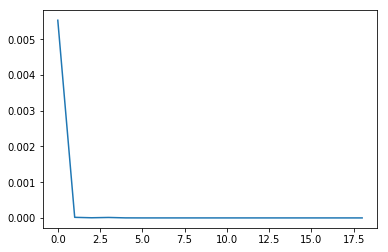

In [11]:
 _ = plt.plot(backfit.output_model_variation['e2'])

In [49]:
for values in backfit.output_model_dict.values():
    print(values.coef_())
    print(values.get_feature_names())

[-0.424]
['x3^0x4^0']
[-0.075 0.095 -0.239 0.062 -0.251 1.086 0.684 0.384 0.249 -0.316 -0.234 0.166 -0.078 -0.102 0.668 0.088 0.078 0.016 -0.024 0.018]
['1', 'x1^0', 'x2^0', 'x2^2', 'x3^0', 'x1^2', 'x1^0x2^0', 'x1^0x3^0', 'x2^0x3^0', 'x3^2', 'x1^3', 'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x2^0x3^0', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3']
[0.026]
['x1^0x5^0']
[-1.009]
['x2^0x4^0']


In [48]:
backfit.evaluate_l1_loss_parameter()

3.523135688723686